# Data preprocessing

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

In [69]:
# Extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox, norm
from statsmodels.genmod.generalized_linear_model import GLM

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
np.random.seed(42)  # The solution.

## Reading CSV

In [72]:
raw_ILDS = read_csv("train_features_ILDS.csv", delimiter=',')
raw_ILDS.columns = ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 
                    'Sgot', 'TP', 'ALB', 'AR']
raw_ILDS['target'] = read_csv("train_labels_ILDS.csv", delimiter=',')
raw_ILDS['Female'] = raw_ILDS['Female'].astype('category')
raw_ILDS['target'] = raw_ILDS['target'].astype('category')

raw_ILDS.shape #tamany

(462, 11)

- Bilirubin (TB & DB): product of the degradation of hemoglobin. It should be processed by the liver and make it water-soluble to be expelled from the body. Direct Bilirubin is the Bilirubin processed by the liver, the Indirect one is the Bilirubin unprocessed, and the total is the sum of the two.
- Alkaline Phosphotase (Alkphos): enzime that breaks down phosphate groups. It is everywhere, but more concentrated in the liver and bones. Liver damages can lead to an increased release of these enzimes.
- Alamine Aminotransferase (Sgpt): enzime that participates in the metabolism of amino acids. Damages in the liver can lead to an increase of these enzimes.
- Aspartate Aminotransferase (Sgot): enzime that participates in the metabolism of amino acids (just like Sgpt). Liver, heart or Muscle injuries can lead to an increase of concentration of these enzimes.
- Total proteins (TP): total of proteins in blood. Problems in liver or kidneys may lead to a decrease of this concentration.
- Albumin (ALB): keeps fluids inside blood vessels and transports substances. Problems in the liver may decrease its concentration, as this proteins is exclusively procused by the Liver.
- Albumin to Globulin (A/R): low ratio may indicate liver problems.

# 1. Basic inspection of the dataset

At first glance the dataset does not have any problems, as there are no explicit missing values (but we don't know if there are imputed missing values in this dataset).

It is worrying that **the number of sick patients is higher than the number of healthy patients** in this dataset. The number of male individuals is much higher than that of female individuals, too.

So we need to **apply resampling** to compensate, at least, **for the lack of balance between sick and healthy patients**.

In [73]:
raw_ILDS.head()

Age Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AR target
0   48      0  4.5  2.3      282    13    74  7.0  2.4  0.52      0
1   39      0  1.9  0.9      180    42    62  7.4  4.3  1.38      0
2   23      0  1.0  0.3      212    41    80  6.2  3.1  1.00      0
3   42      1  0.7  0.2      152    35    81  6.2  3.2  1.06      0
4   52      1  0.6  0.1      194    10    12  6.9  3.3  0.90      1

In [74]:
raw_ILDS.describe()

Age       TB       DB   Alkphos      Sgpt      Sgot       TP  \
count  462.000  462.000  462.000   462.000   462.000   462.000  462.000   
mean    44.892    3.277    1.445   279.714    73.952    94.571    6.421   
std     16.325    6.121    2.678   211.487   164.499   202.027    1.053   
min      4.000    0.400    0.100    75.000    10.000    11.000    2.700   
25%     33.000    0.800    0.200   176.000    23.000    25.000    5.700   
50%     45.000    1.000    0.300   208.000    34.000    41.000    6.500   
75%     57.750    2.675    1.275   290.000    59.750    82.750    7.100   
max     90.000   75.000   18.300  1630.000  2000.000  2946.000    9.500   

           ALB       AR  
count  462.000  462.000  
mean     3.108    0.942  
std      0.793    0.318  
min      0.900    0.300  
25%      2.500    0.700  
50%      3.100    0.910  
75%      3.700    1.100  
max      5.500    2.800

In [75]:
raw_ILDS['Female'].value_counts() 

Female
0    350
1    112
Name: count, dtype: int64

In [76]:
raw_ILDS[raw_ILDS['Female'] == 1]['target'].value_counts()

target
0    74
1    38
Name: count, dtype: int64

In [77]:
raw_ILDS[raw_ILDS['Female'] == 0]['target'].value_counts()

target
0    256
1     94
Name: count, dtype: int64

We are now going to build scatterplots of all of our variables. At first glance there is no clear separation between sick and healthy patients, but this may be because we are looking at the dataset from the "wrong perspective".

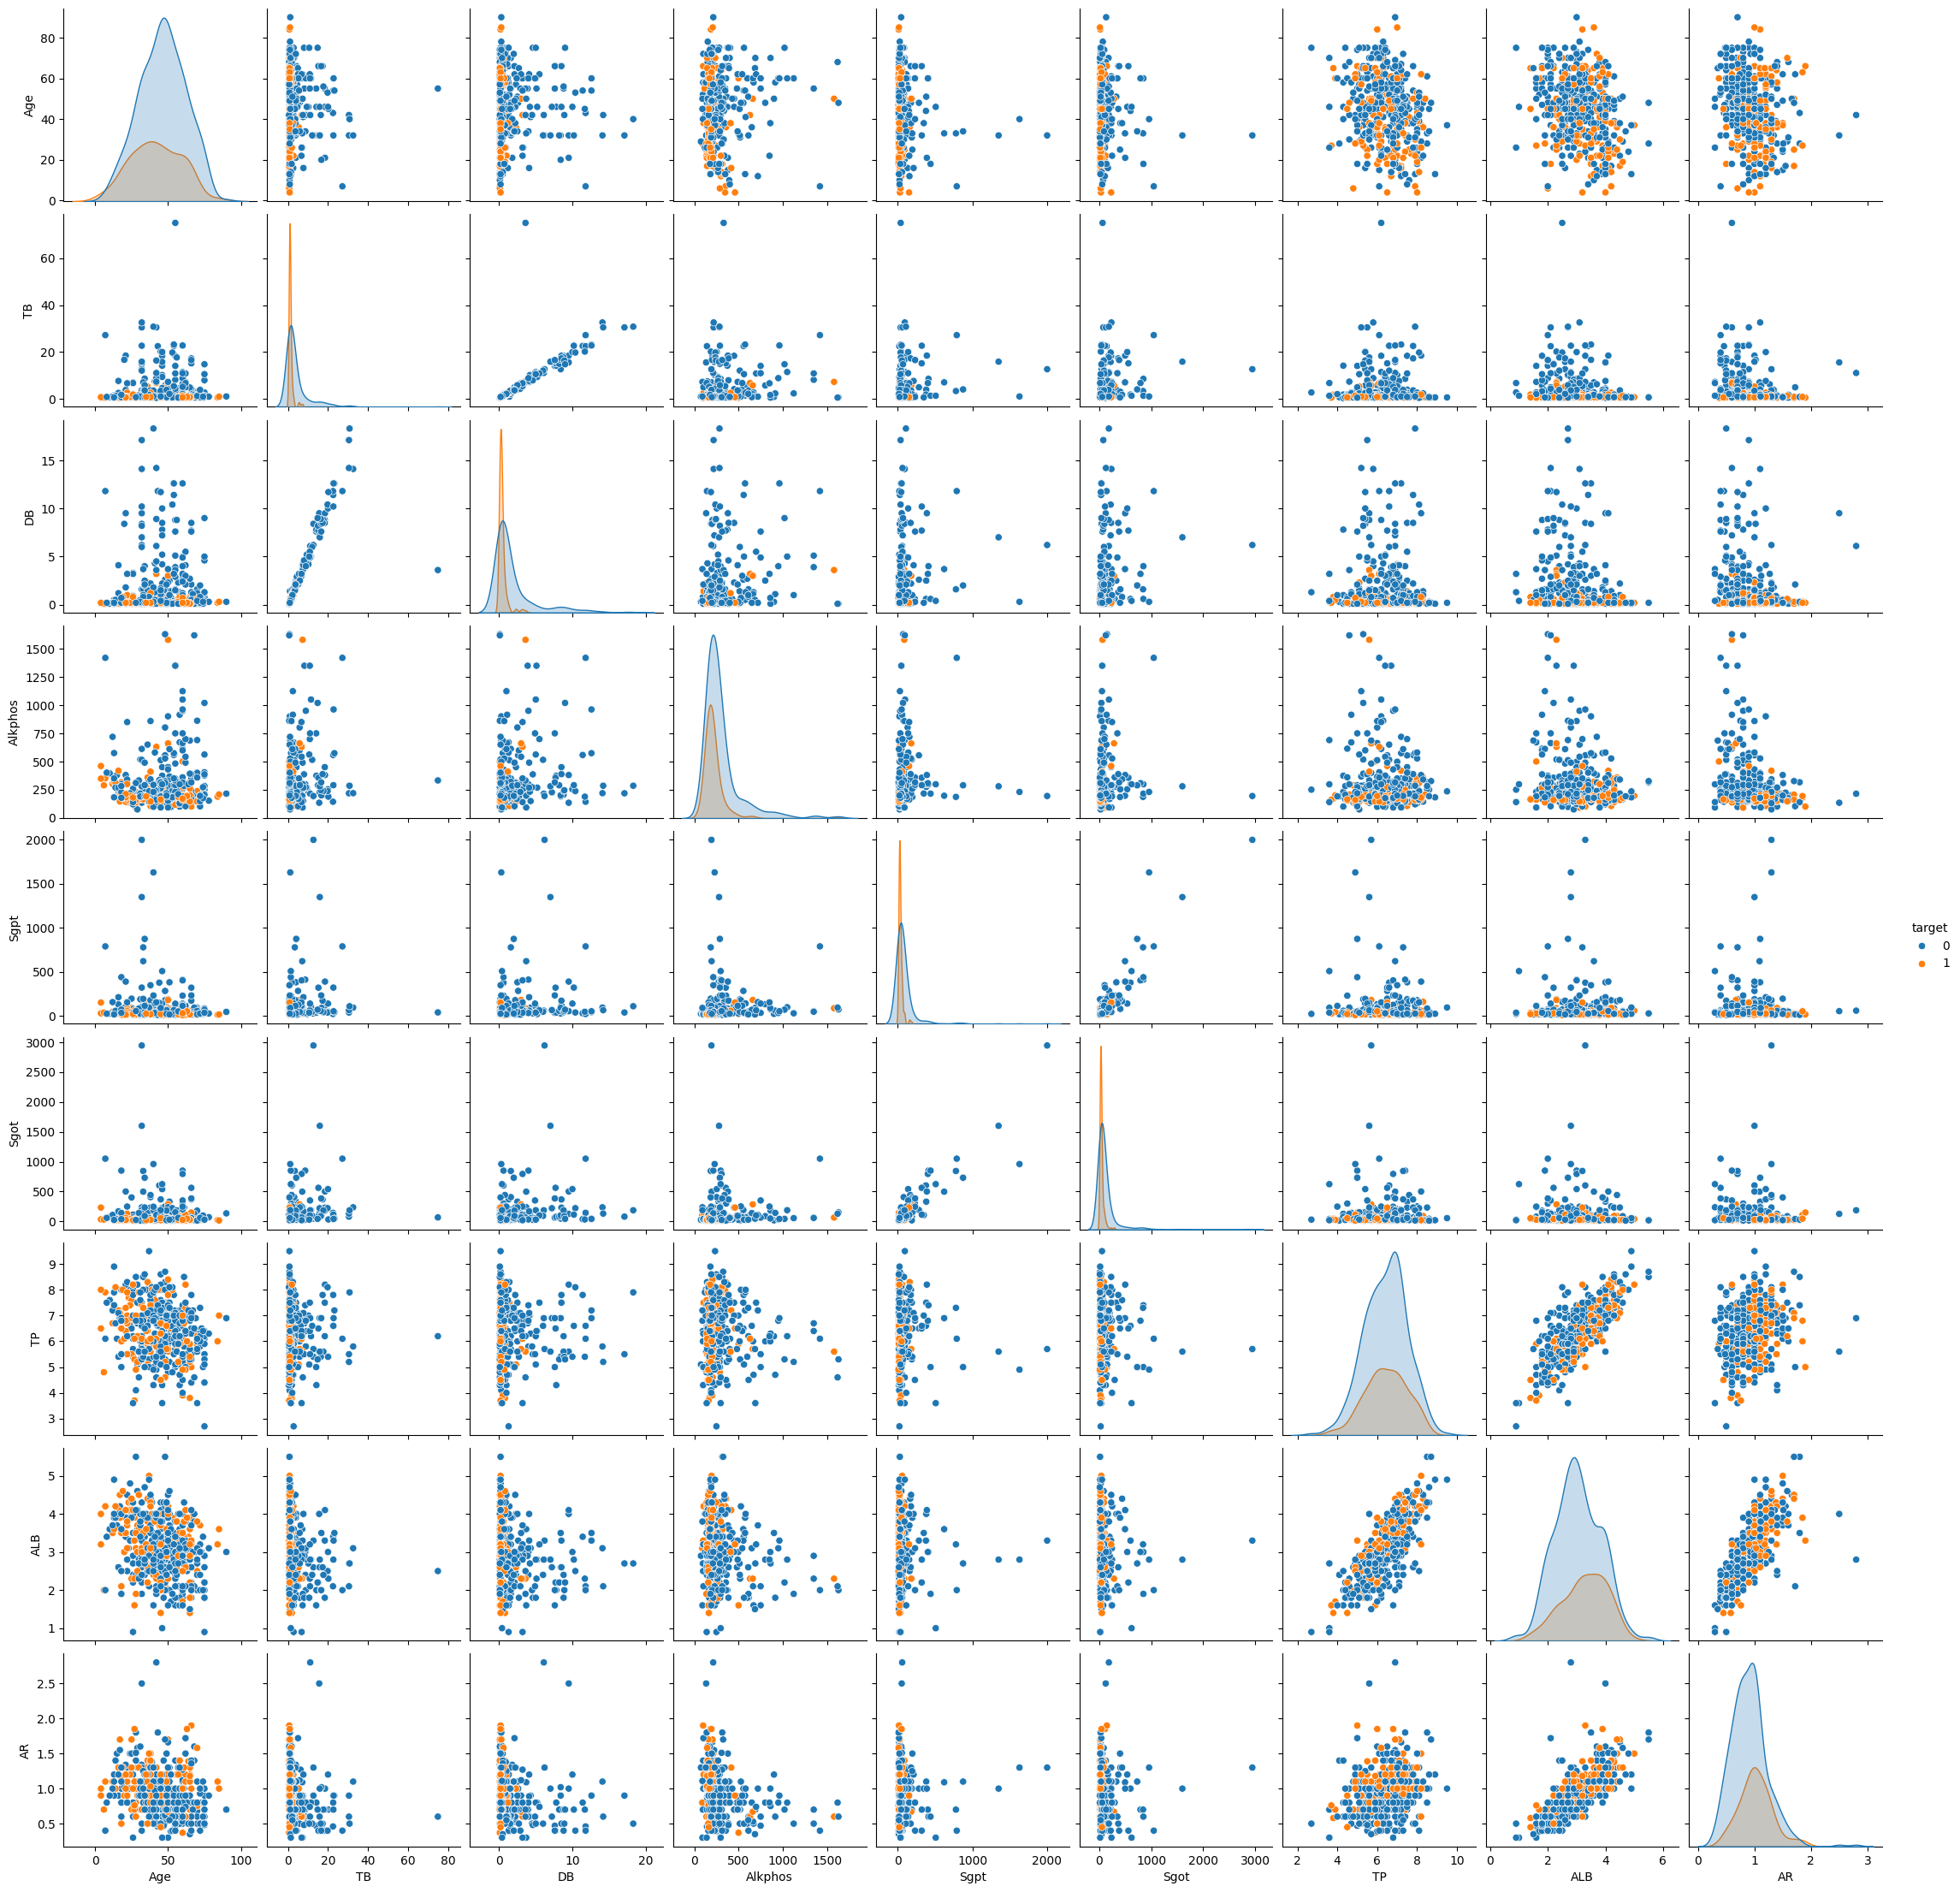

In [78]:
sns.pairplot(raw_ILDS, hue = "target")

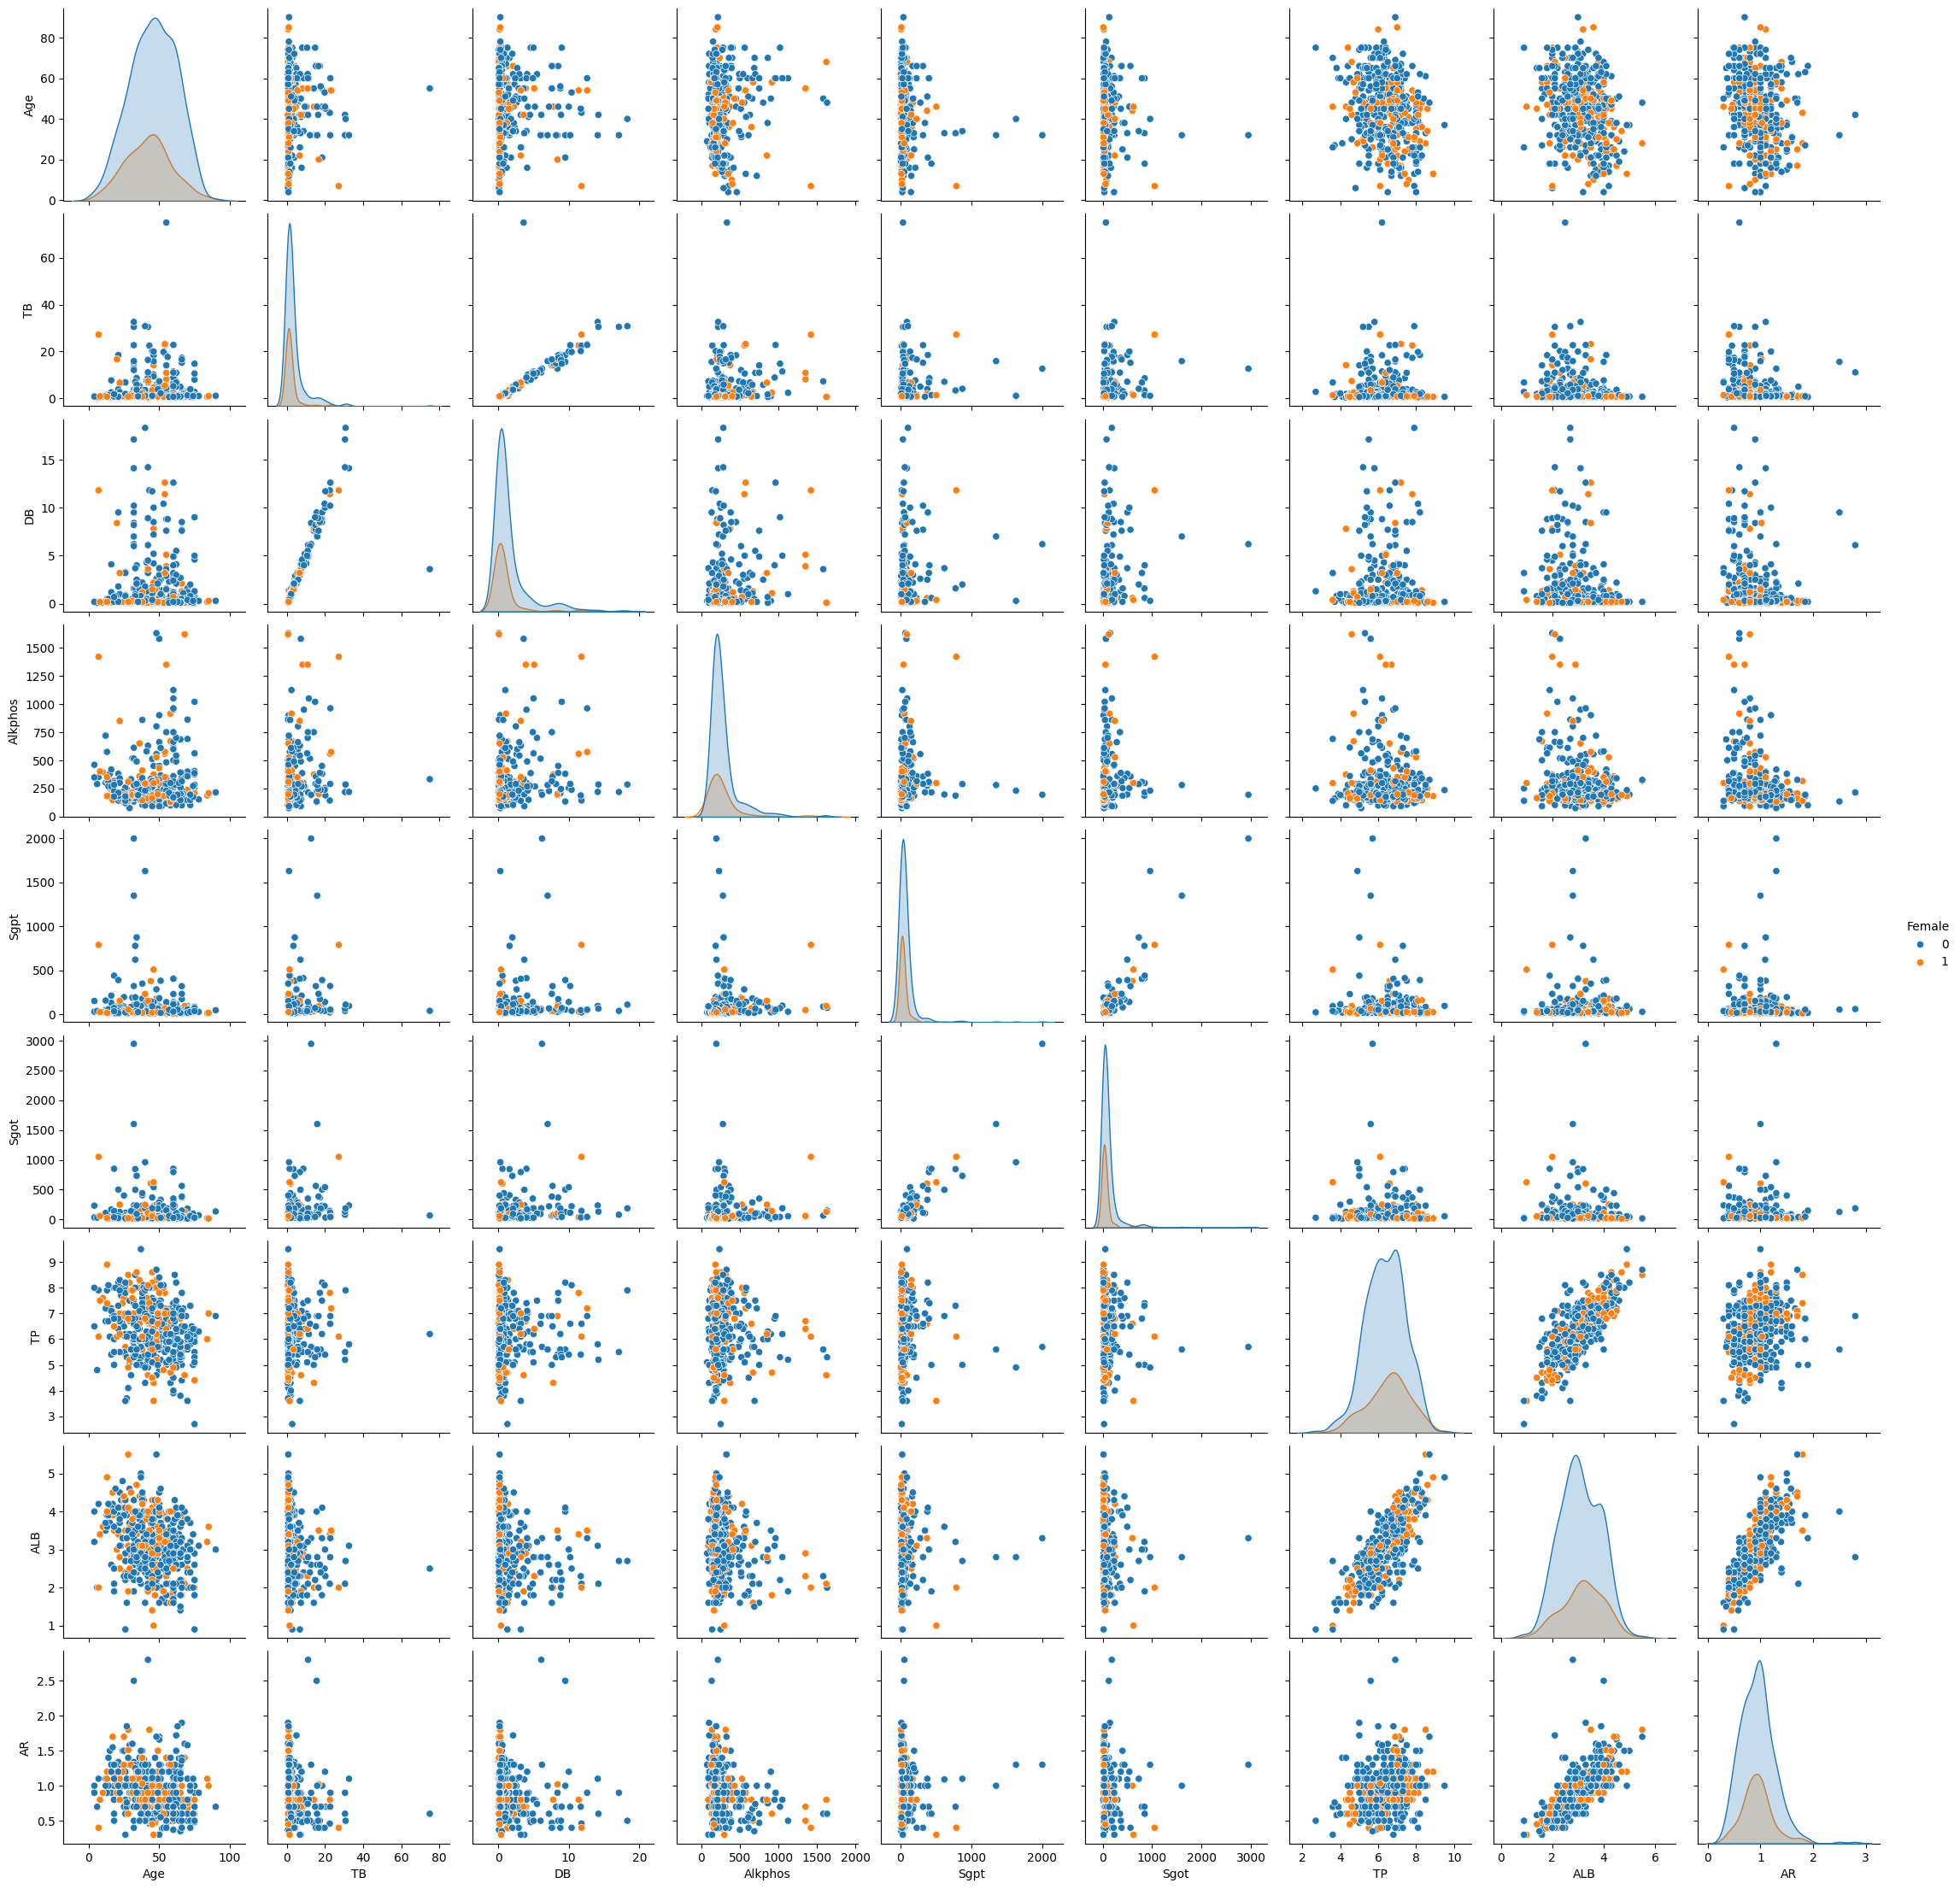

In [79]:
sns.pairplot(raw_ILDS, hue = "Female")

We can try to appy PCA to this dataset, which ends up being successful as 2 dimensions captures more than 95% of the total variance of the whole dataset. The problem is that when visualizing the dataset in the 2 most important dimensions, **there is still no clear difference between a sick and healthy patient**.

But this was still a very useful analysis, because we have identified **4 individuals in our dataset which are clearly outliers**. We can easily distinguish them because they are far away from the others. We need to remove these outliers as they might be clouding our PCA analysis (or, in general, hindering our data analysis).

In [80]:
raw_numILDS = raw_ILDS.drop(columns = ["Female", "target"])
corr = raw_numILDS.corr()
corr.style.background_gradient(cmap='RdBu')

In [81]:
eigs, U = np.linalg.eig(corr) 
X_pca = raw_numILDS @ U

print(eigs)
print(X_pca.shape)

[2.84731721 2.08367591 1.42377151 0.83860588 0.88428466 0.64125701
 0.04482713 0.08658912 0.14967158]
(462, 9)


<Figure size 600x400 with 0 Axes>

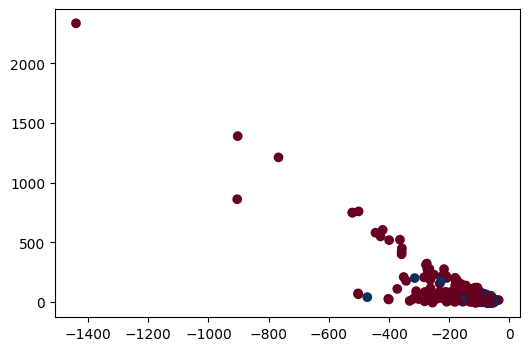

In [82]:
x = X_pca.loc[:, 0]
y = X_pca.loc[:, 1]
z = X_pca.loc[:, 2]

plt.figure(figsize = (6, 4))
_ = plt.scatter(x = x, y = y, c = raw_ILDS['target'], cmap = "RdBu")

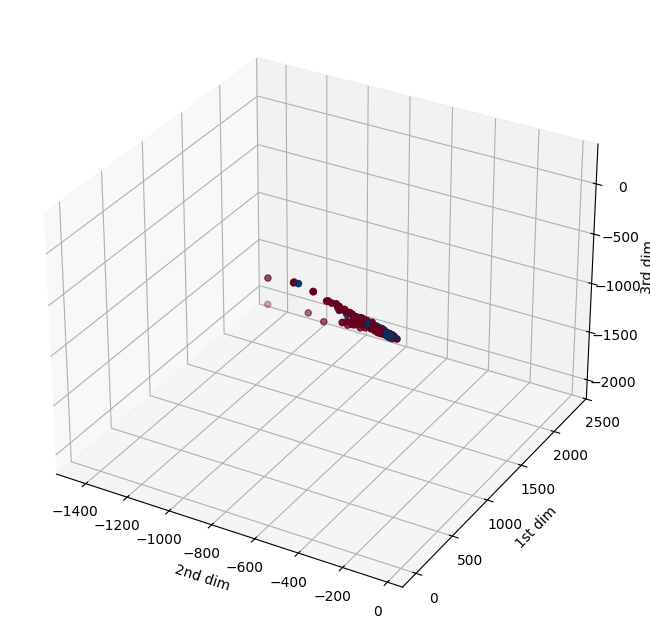

In [83]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs = x, ys = y, zs = z, c = raw_ILDS['target'], cmap = "RdBu")

_ = ax.set_xlabel("2nd dim")
_ = ax.set_ylabel("1st dim")
_ = ax.set_zlabel("3rd dim")

# 2. Removing outliers

### General outliers

From PCA analysis, we have decided to remove 4 individuals which are clearly outliers.

In [84]:
outliers = X_pca.loc[:, 0] < -600
outliers.value_counts()

0
False    458
True       4
Name: count, dtype: int64

In [85]:
no_outs_ILDS = raw_ILDS[np.logical_not(outliers)]
raw_ILDS.describe()

Age       TB       DB   Alkphos      Sgpt      Sgot       TP  \
count  462.000  462.000  462.000   462.000   462.000   462.000  462.000   
mean    44.892    3.277    1.445   279.714    73.952    94.571    6.421   
std     16.325    6.121    2.678   211.487   164.499   202.027    1.053   
min      4.000    0.400    0.100    75.000    10.000    11.000    2.700   
25%     33.000    0.800    0.200   176.000    23.000    25.000    5.700   
50%     45.000    1.000    0.300   208.000    34.000    41.000    6.500   
75%     57.750    2.675    1.275   290.000    59.750    82.750    7.100   
max     90.000   75.000   18.300  1630.000  2000.000  2946.000    9.500   

           ALB       AR  
count  462.000  462.000  
mean     3.108    0.942  
std      0.793    0.318  
min      0.900    0.300  
25%      2.500    0.700  
50%      3.100    0.910  
75%      3.700    1.100  
max      5.500    2.800

In [86]:
no_outs_ILDS.describe()

Age       TB       DB  Alkphos     Sgpt     Sgot       TP      ALB  \
count  458.000  458.000  458.000   458.00  458.000  458.000  458.000  458.000   
mean    45.041    3.182    1.403   277.52   62.000   81.083    6.429    3.112   
std     16.275    5.999    2.623   205.54   95.148  120.842    1.054    0.795   
min      4.000    0.400    0.100    75.00   10.000   11.000    2.700    0.900   
25%     33.000    0.800    0.200   176.00   23.000   25.000    5.700    2.500   
50%     45.000    1.000    0.300   208.00   33.500   41.000    6.500    3.100   
75%     58.000    2.600    1.200   290.00   58.750   80.000    7.100    3.700   
max     90.000   75.000   18.300  1630.00  875.000  850.000    9.500    5.500   

            AR  
count  458.000  
mean     0.942  
std      0.318  
min      0.300  
25%      0.700  
50%      0.900  
75%      1.100  
max      2.800

We now apply PCA again. Once again, there is no clear distinction between what a sick and healthy patient should be as the clouds of points are very near each other. But it is a good starting point because we have removed the 4 most prominent outliers, which could have been problematic.

**NOTA PEL HAO: Observa el plot 2D de les dues primeres dimensions. Veus que hi ha un outlier de pacients sans a la dreta del tot? Si volem usar un k-nearest neighbors o potser fins i tot un SVM amb algun kernel estrany, la funció de probabilitat pot ser més alta allà del que hauria de ser o es pot liar el SVM... Encara pitjor, és possible que en el resampling, si el féssim automàtic, apareguessin punts allà que no tenen sentit. Tú que penses? L'hem d'eliminar?**

**I després podriem considerar eliminar algun punt més, però potser seria passar-se? No sé...**

In [87]:
no_outs_numILDS = no_outs_ILDS.drop(columns = ["Female", "target"])
corr = no_outs_numILDS.corr()
corr.style.background_gradient(cmap='RdBu')

In [88]:
eigs, U = np.linalg.eig(corr) 
X_pca = no_outs_numILDS @ U

print(eigs)
print(X_pca.shape)

[2.83737052 1.99789175 1.41053143 0.91236037 0.83475683 0.65434967
 0.04446727 0.14618232 0.16208983]
(458, 9)


<Figure size 600x400 with 0 Axes>

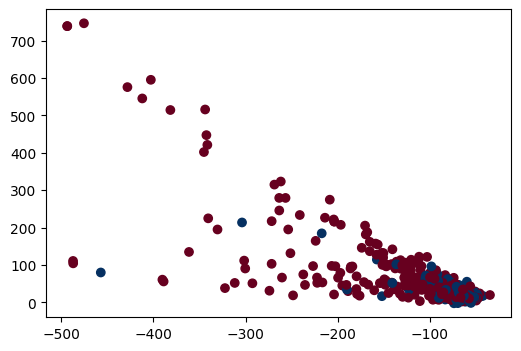

In [89]:
x = X_pca.loc[:, 0]
y = X_pca.loc[:, 1]
z = X_pca.loc[:, 2]

plt.figure(figsize = (6, 4))
plt.scatter(x = x, y = y, c = no_outs_ILDS['target'], cmap = "RdBu")

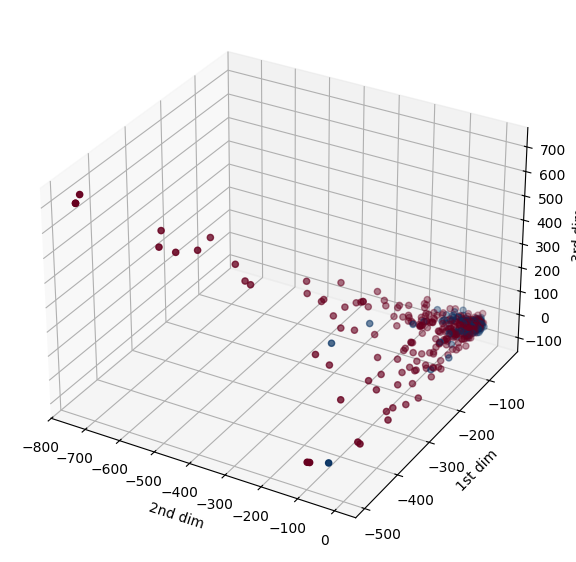

In [90]:
fig = plt.figure(figsize = (7, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs = -y, ys = x, zs = z, c = no_outs_ILDS['target'], cmap = "RdBu")

_ = ax.set_xlabel("2nd dim")
_ = ax.set_ylabel("1st dim")
_ = ax.set_zlabel("3rd dim")

In [91]:
(no_outs_ILDS['TB'] < no_outs_ILDS['DB']).value_counts()

False    457
True       1
Name: count, dtype: int64

## Individual analysis of each variable

We will take a look at every variable individually. We will attempt to find outliers for those values and if necessary we will eliminate them. We will also consider whether we need to apply transformations to them.

Transformations needed (generally BoxCox):
- Total and direct bilirubin
- Alkaline Phosphotase
- Alamine Aminotransferase
- Aspartate Aminotransferase

Outliers found right now:
- TB: Very important outlier with value 75. Could be eliminated.
- DB: We would need to apply a suitable Box-Cox transformation before analyzing whether there are plausible outliers or not...
- Alkphos: Plausible outliers at the far right end.
- Sgpt: Notable outlier at the far right.
- Proteins: Far left.
- AR: Far right.

In [92]:
def histbox (data, column: str, n_bins: int = 10) -> None:
    fig, axes = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [1, 4]}, figsize=(9,4))
    sns.boxplot(data = data, x = 'target', y = column, hue = 'target', ax = axes[0])
    
    sick = data[data["target"] == 0]
    healthy = data[data["target"] == 1]
    mean_sick = np.mean(sick[column])
    mean_healthy = np.mean(healthy[column])
    std_sick = np.std(sick[column])
    std_healthy = np.std(healthy[column])
    prop_sick = len(sick) / len(data)
    prop_healthy = len(healthy) / len(data)
    
    x = np.linspace(np.min(sick[column]), np.max(sick[column]), num = 500)
    y = np.linspace(np.min(healthy[column]), np.max(healthy[column]), num = 500)
    ax = sns.histplot(data = data, x = column, hue = 'target', ax = axes[1],
                      bins = n_bins, stat = "density")
    ax.plot(x, norm.pdf(x, loc = mean_sick, scale = std_sick) * prop_sick)
    ax.plot(y, norm.pdf(y, loc = mean_healthy, scale = std_healthy) * prop_healthy)

### Age

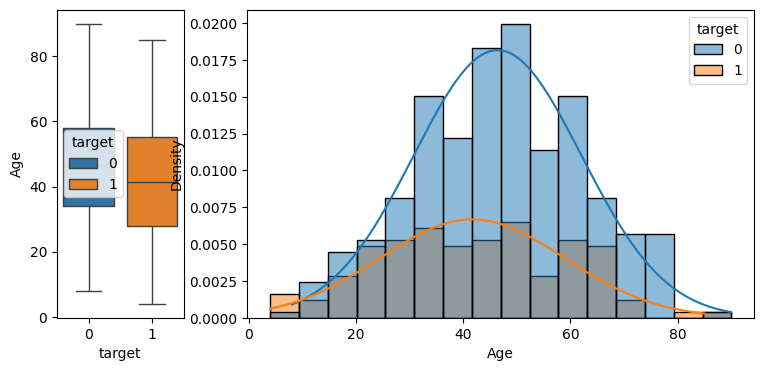

In [93]:
histbox(no_outs_ILDS, "Age", 16)

### Total Bilirubin

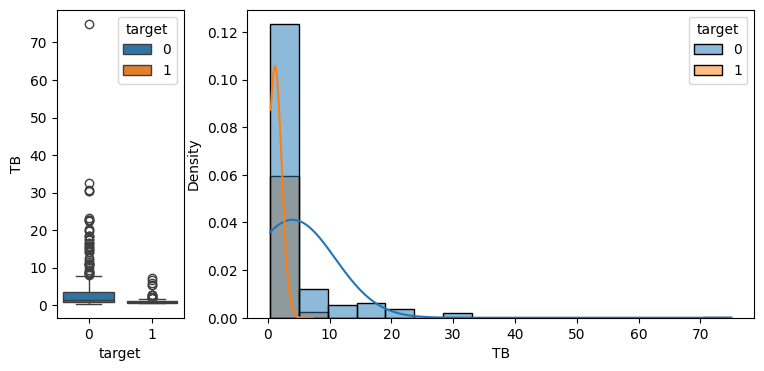

In [94]:
histbox(no_outs_ILDS, "TB", 16)

In [95]:
(no_outs_ILDS.TB < 70).value_counts() # TODO: potser no és un missing value, i realment algú el tenia tan alt?

TB
True     457
False      1
Name: count, dtype: int64

In [96]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.TB < 70]

### Direct Bilirubin

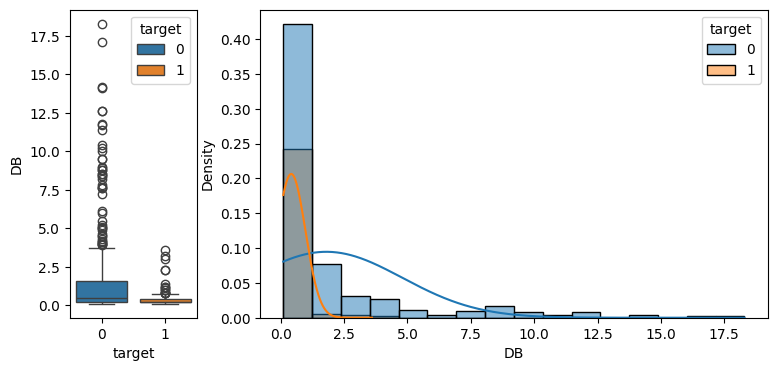

In [97]:
histbox(no_outs_ILDS, "DB", 16)

### Indirect Bilirubin

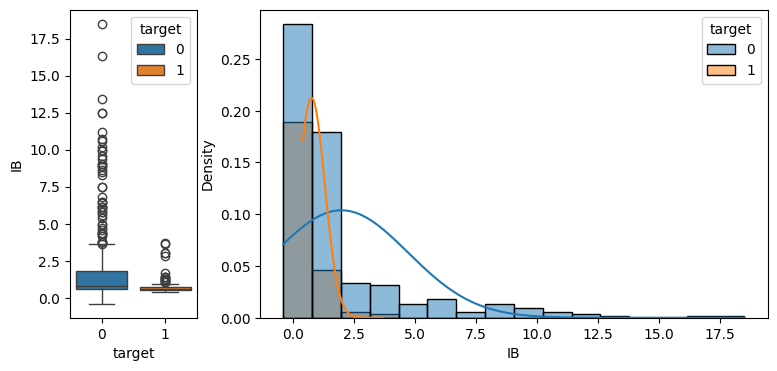

In [98]:
no_outs_ILDS["IB"] = no_outs_ILDS["TB"] - no_outs_ILDS["DB"]
histbox(no_outs_ILDS, "IB", 16)

In [99]:
(no_outs_ILDS.IB < 0).value_counts()

IB
False    456
True       1
Name: count, dtype: int64

In [100]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.IB >= 0]

### Alkaline Phosphotase

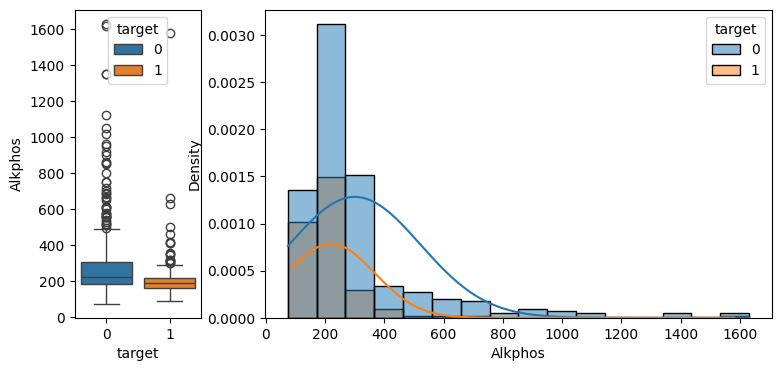

In [101]:
histbox(no_outs_ILDS, "Alkphos", 16) # TODO: Logarithmic també?

In [102]:
(no_outs_ILDS.Alkphos < 1200).value_counts()

Alkphos
True     451
False      5
Name: count, dtype: int64

In [103]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.Alkphos < 1200]

### Alamine Aminotransferase

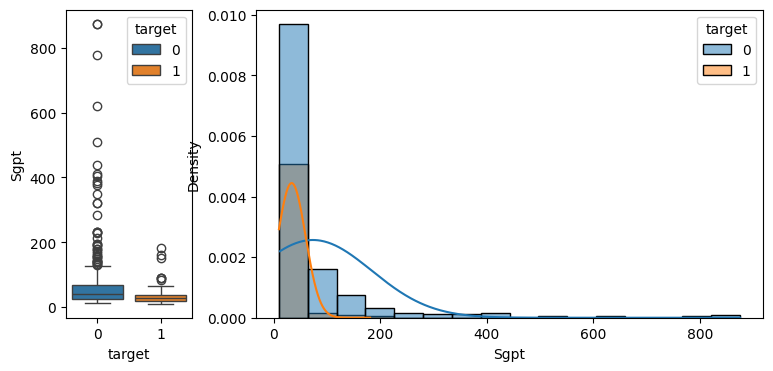

In [104]:
histbox(no_outs_ILDS, "Sgpt", 16) # TODO: Logarithmic també?

In [105]:
(no_outs_ILDS.Sgpt < 700).value_counts()

Sgpt
True     448
False      3
Name: count, dtype: int64

In [106]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.Sgpt < 700]

### Aspartate Aminotransferase

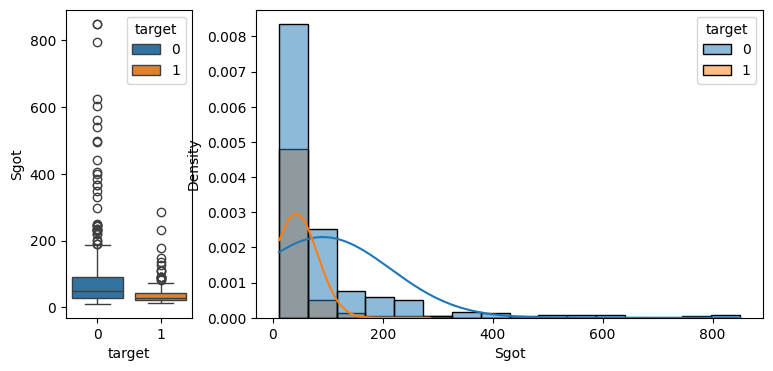

In [107]:
histbox(no_outs_ILDS, "Sgot", 16) # TODO: Res sembla una normal :D

In [108]:
(no_outs_ILDS.Sgot < 700).value_counts()

Sgot
True     445
False      3
Name: count, dtype: int64

In [109]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.Sgot < 700]

### Total Proteins

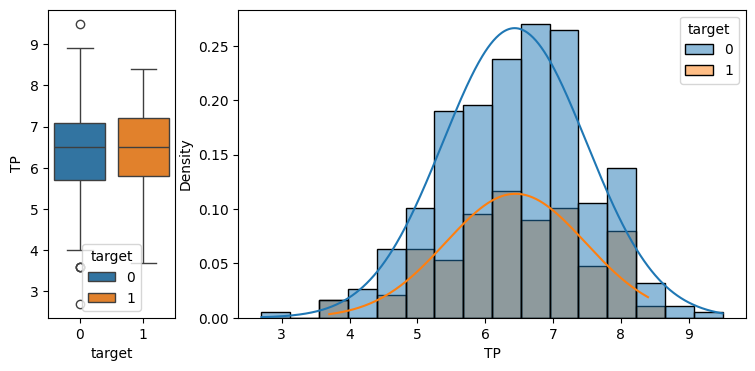

In [110]:
histbox(no_outs_ILDS, "TP", 16)

### Albumin

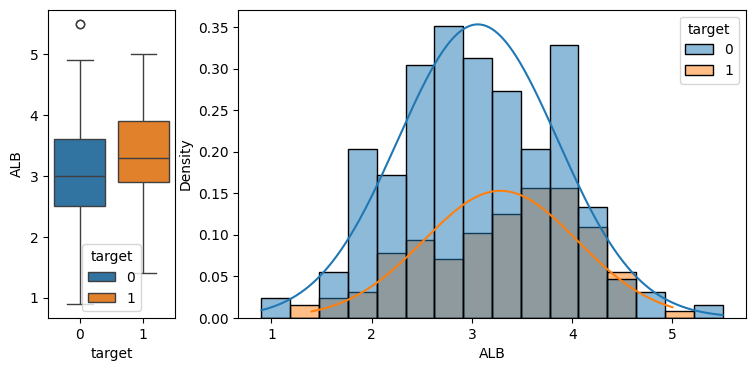

In [111]:
histbox(no_outs_ILDS, "ALB", 16) # Cool

In [112]:
(no_outs_ILDS.ALB < 5).value_counts()

ALB
True     442
False      3
Name: count, dtype: int64

In [113]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.ALB < 5]

### Albumin and Globulin Ratio

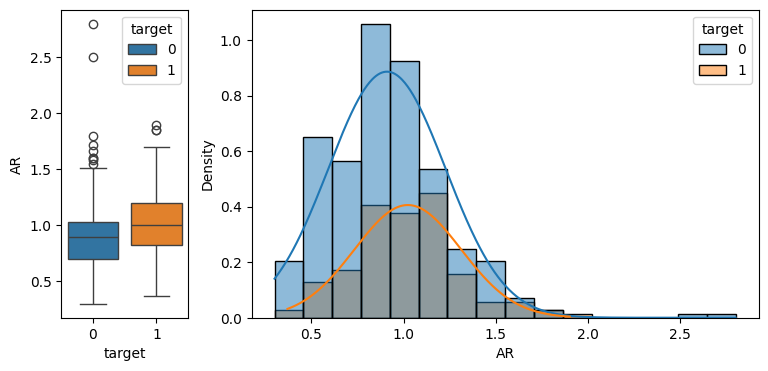

In [114]:
histbox(no_outs_ILDS, "AR", 16)

In [115]:
(no_outs_ILDS.AR < 2.2).value_counts()

AR
True     440
False      2
Name: count, dtype: int64

In [116]:
no_outs_ILDS = no_outs_ILDS[no_outs_ILDS.AR < 2.2]

In [117]:
print(no_outs_ILDS)

     Age Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AR target   IB
0     48      0  4.5  2.3      282    13    74  7.0  2.4  0.52      0  2.2
1     39      0  1.9  0.9      180    42    62  7.4  4.3  1.38      0  1.0
2     23      0  1.0  0.3      212    41    80  6.2  3.1  1.00      0  0.7
3     42      1  0.7  0.2      152    35    81  6.2  3.2  1.06      0  0.5
4     52      1  0.6  0.1      194    10    12  6.9  3.3  0.90      1  0.5
..   ...    ...  ...  ...      ...   ...   ...  ...  ...   ...    ...  ...
457   18      0  1.8  0.7      178    35    36  6.8  3.6  1.10      0  1.1
458   49      1  0.8  0.2      198    23    20  7.0  4.3  1.50      0  0.6
459   51      0  2.2  1.0      610    17    28  7.3  2.6  0.55      0  1.2
460   45      0  1.1  0.4       92    91   188  7.2  3.8  1.11      0  0.7
461    8      1  0.9  0.2      401    25    58  7.5  3.4  0.80      0  0.7

[440 rows x 12 columns]


## Logarithm transformations

In [118]:
log_ILDS = no_outs_ILDS.drop(columns = ['TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot'])

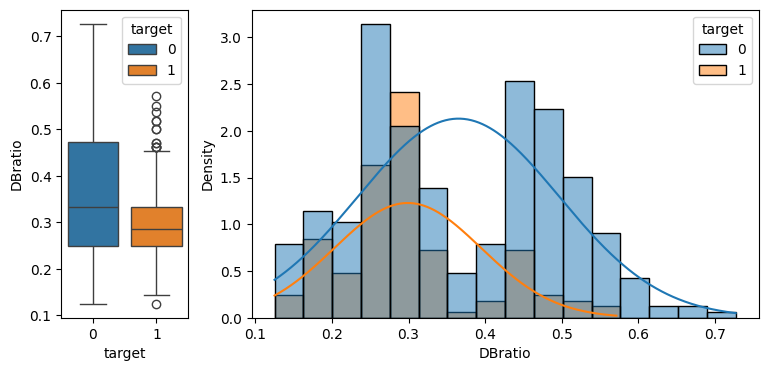

In [119]:
log_ILDS['DBratio'] = no_outs_ILDS['DB'] / no_outs_ILDS['TB']
histbox(log_ILDS, "DBratio", 16)

### Total Bilirubin

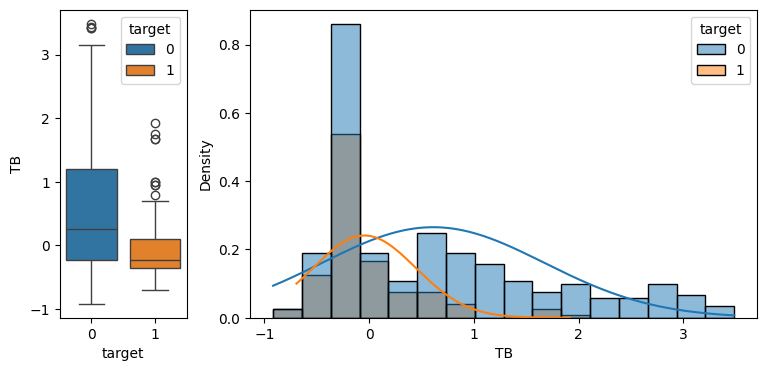

In [120]:
log_ILDS['TB'] = np.log(no_outs_ILDS['TB'])
histbox(log_ILDS, "TB", 16)

### Direct Birilubin

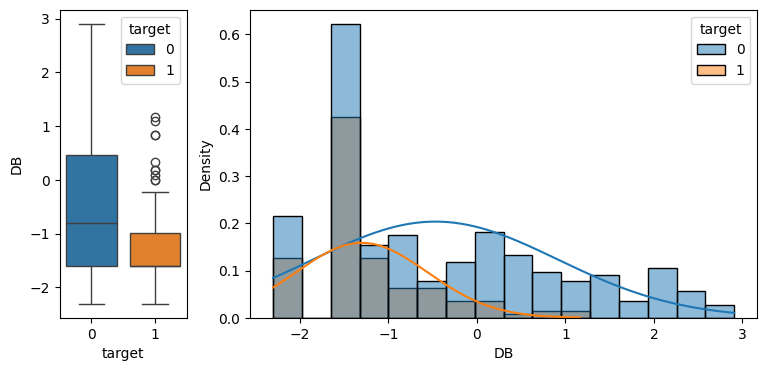

In [121]:
log_ILDS['DB'] = np.log(no_outs_ILDS['DB'])
histbox(log_ILDS, "DB", 16)

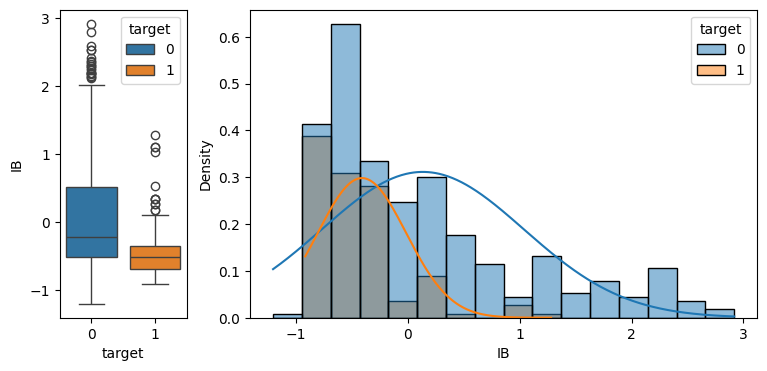

In [122]:
log_ILDS['IB'] = np.log(no_outs_ILDS['IB'])
histbox(log_ILDS, "IB", 16)

### Alkphos

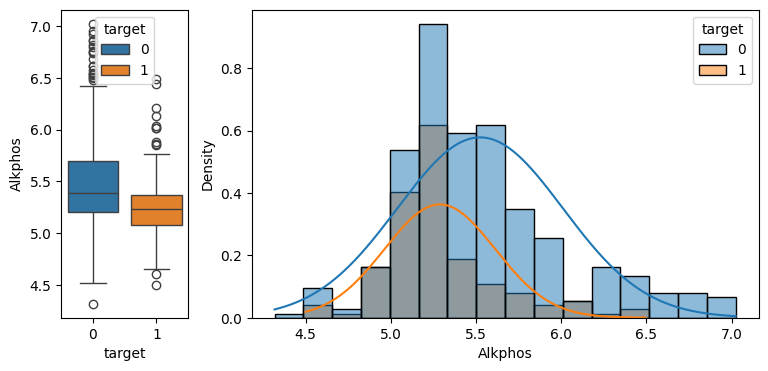

In [123]:
log_ILDS['Alkphos'] = np.log(no_outs_ILDS['Alkphos'])
histbox(log_ILDS, "Alkphos", 16)

### Sgpt

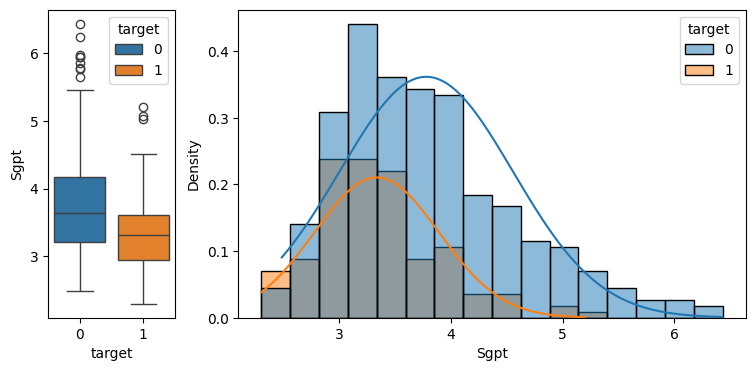

In [124]:
log_ILDS['Sgpt'] = np.log(no_outs_ILDS['Sgpt'])
histbox(log_ILDS, "Sgpt", 16)

### Sgot

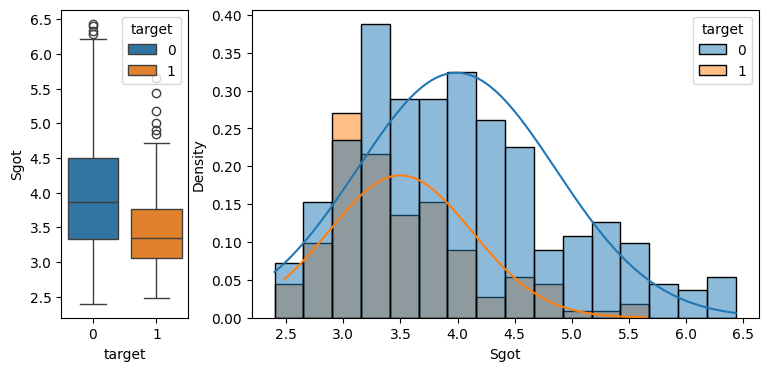

In [125]:
log_ILDS['Sgot'] = np.log(no_outs_ILDS['Sgot'])
histbox(log_ILDS, "Sgot", 16)

# Preprocessing

After eliminating outliers from our training dataset, we decide to make the following transformations to our data:

- Creation of new variable DBratio
- Logarithm transformations on TB, DB, Alkphos, Sgpt and Sgot
- Standardizing of all of our variables to zero mean and variance 1.
- Resampling of the minority class ONLY FOR THE TRAIN DATA.

For consistency we use the same scaler for the train and test data. We train a scaler from our train data and use it on the test data.

In [127]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC

def preprocessing (data: pd.DataFrame, scaler: StandardScaler | None = None,
                   train_data: bool = False):
    # New variables
    new_data = data.drop(columns = ['TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot'])
    new_data['DBratio'] = data['TB'] / data['DB']
    new_data['TB'] = np.log(data['TB'])
    new_data['DB'] = np.log(data['DB'])
    new_data['Alkphos'] = np.log(data['Alkphos'])
    new_data['Sgpt'] = np.log(data['Sgpt'])
    new_data['Sgot'] = np.log(data['Sgot'])
    # Scaling
    if train_data:
        numerical_vars = new_data.drop(columns = ["Female", "target"])
    else:
        numerical_vars = new_data.drop(columns = ["Female"])
    if scaler is None:
        scaler = StandardScaler()
        numerical_vars = scaler.fit_transform(numerical_vars)
    else:
        numerical_vars = scaler.transform(numerical_vars)
    result = pd.DataFrame(numerical_vars)
    new_data.index = result.index
    result['Female'] = new_data['Female']
    result.columns = ['Age', 'TP', 'ALB', 'AR', 'DBratio', 'logTB', 'logDB', 'logAlkphos', 'logSgpt', 
                     'logSgot', 'Female']
    # Resampling (only for train_data)
    if train_data:
        smotenc = SMOTENC(sampling_strategy = "minority", random_state = 42,
                         categorical_features = ["Female"])
        X_resampled, y_resampled = smotenc.fit_resample(result, new_data['target'])
        result = X_resampled
        result['Target'] = y_resampled
    # Return
    return result, scaler
    
if "IB" in no_outs_ILDS.columns:
    no_outs_ILDS = no_outs_ILDS.drop(columns = ["IB"])
    
test_data = read_csv("test_data_ILDS.csv", delimiter=',', header=None)
test_data.columns = ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 
                    'Sgot', 'TP', 'ALB', 'AR']
test_data['Female'] = test_data['Female'].astype('category')

log_ILDS_train, scaler = preprocessing(no_outs_ILDS, train_data = True)
log_ILDS_test_X, _ = preprocessing(test_data, scaler)

print(log_ILDS_train)

       Age     TP    ALB     AR  DBratio  logTB  logDB  logAlkphos  logSgpt  \
0    0.180  0.553 -0.911 -1.419   -1.020  1.113  1.204       0.410   -1.447   
1   -0.370  0.937  1.534  1.523   -0.907  0.229  0.474      -0.571    0.121   
2   -1.346 -0.216 -0.011  0.223   -0.010 -0.429 -0.381      -0.213    0.088   
3   -0.186 -0.216  0.118  0.428    0.112 -0.795 -0.697      -0.941   -0.123   
4    0.424  0.457  0.247 -0.120    1.947 -0.953 -1.236      -0.407   -1.798   
..     ...    ...    ...    ...      ...    ...    ...         ...      ...   
615 -0.459 -0.657 -0.099 -0.408   -0.771  0.492  0.613       1.092    0.532   
616 -1.636  0.624  0.954  0.855    0.021 -0.730 -0.618      -0.929   -1.012   
617 -0.953  1.249  1.637  1.061   -1.100  0.286  0.621      -1.229   -0.967   
618 -1.180  0.306  0.321  0.125   -0.255 -0.953 -0.697      -0.693   -1.341   
619 -1.167 -0.249 -0.139 -0.120   -0.255 -0.483 -0.341      -0.655   -1.104   

     logSgot Female Target  
0      0.550      0   

In [128]:
print(log_ILDS_train["Target"].value_counts())

Target
0    310
1    310
Name: count, dtype: int64


In [129]:
print(log_ILDS_train.isna().value_counts())

Age    TP     ALB    AR     DBratio  logTB  logDB  logAlkphos  logSgpt  logSgot  Female  Target
False  False  False  False  False    False  False  False       False    False    False   False     620
Name: count, dtype: int64


# Doing a bit of analysis again to avaluate results of oversampling

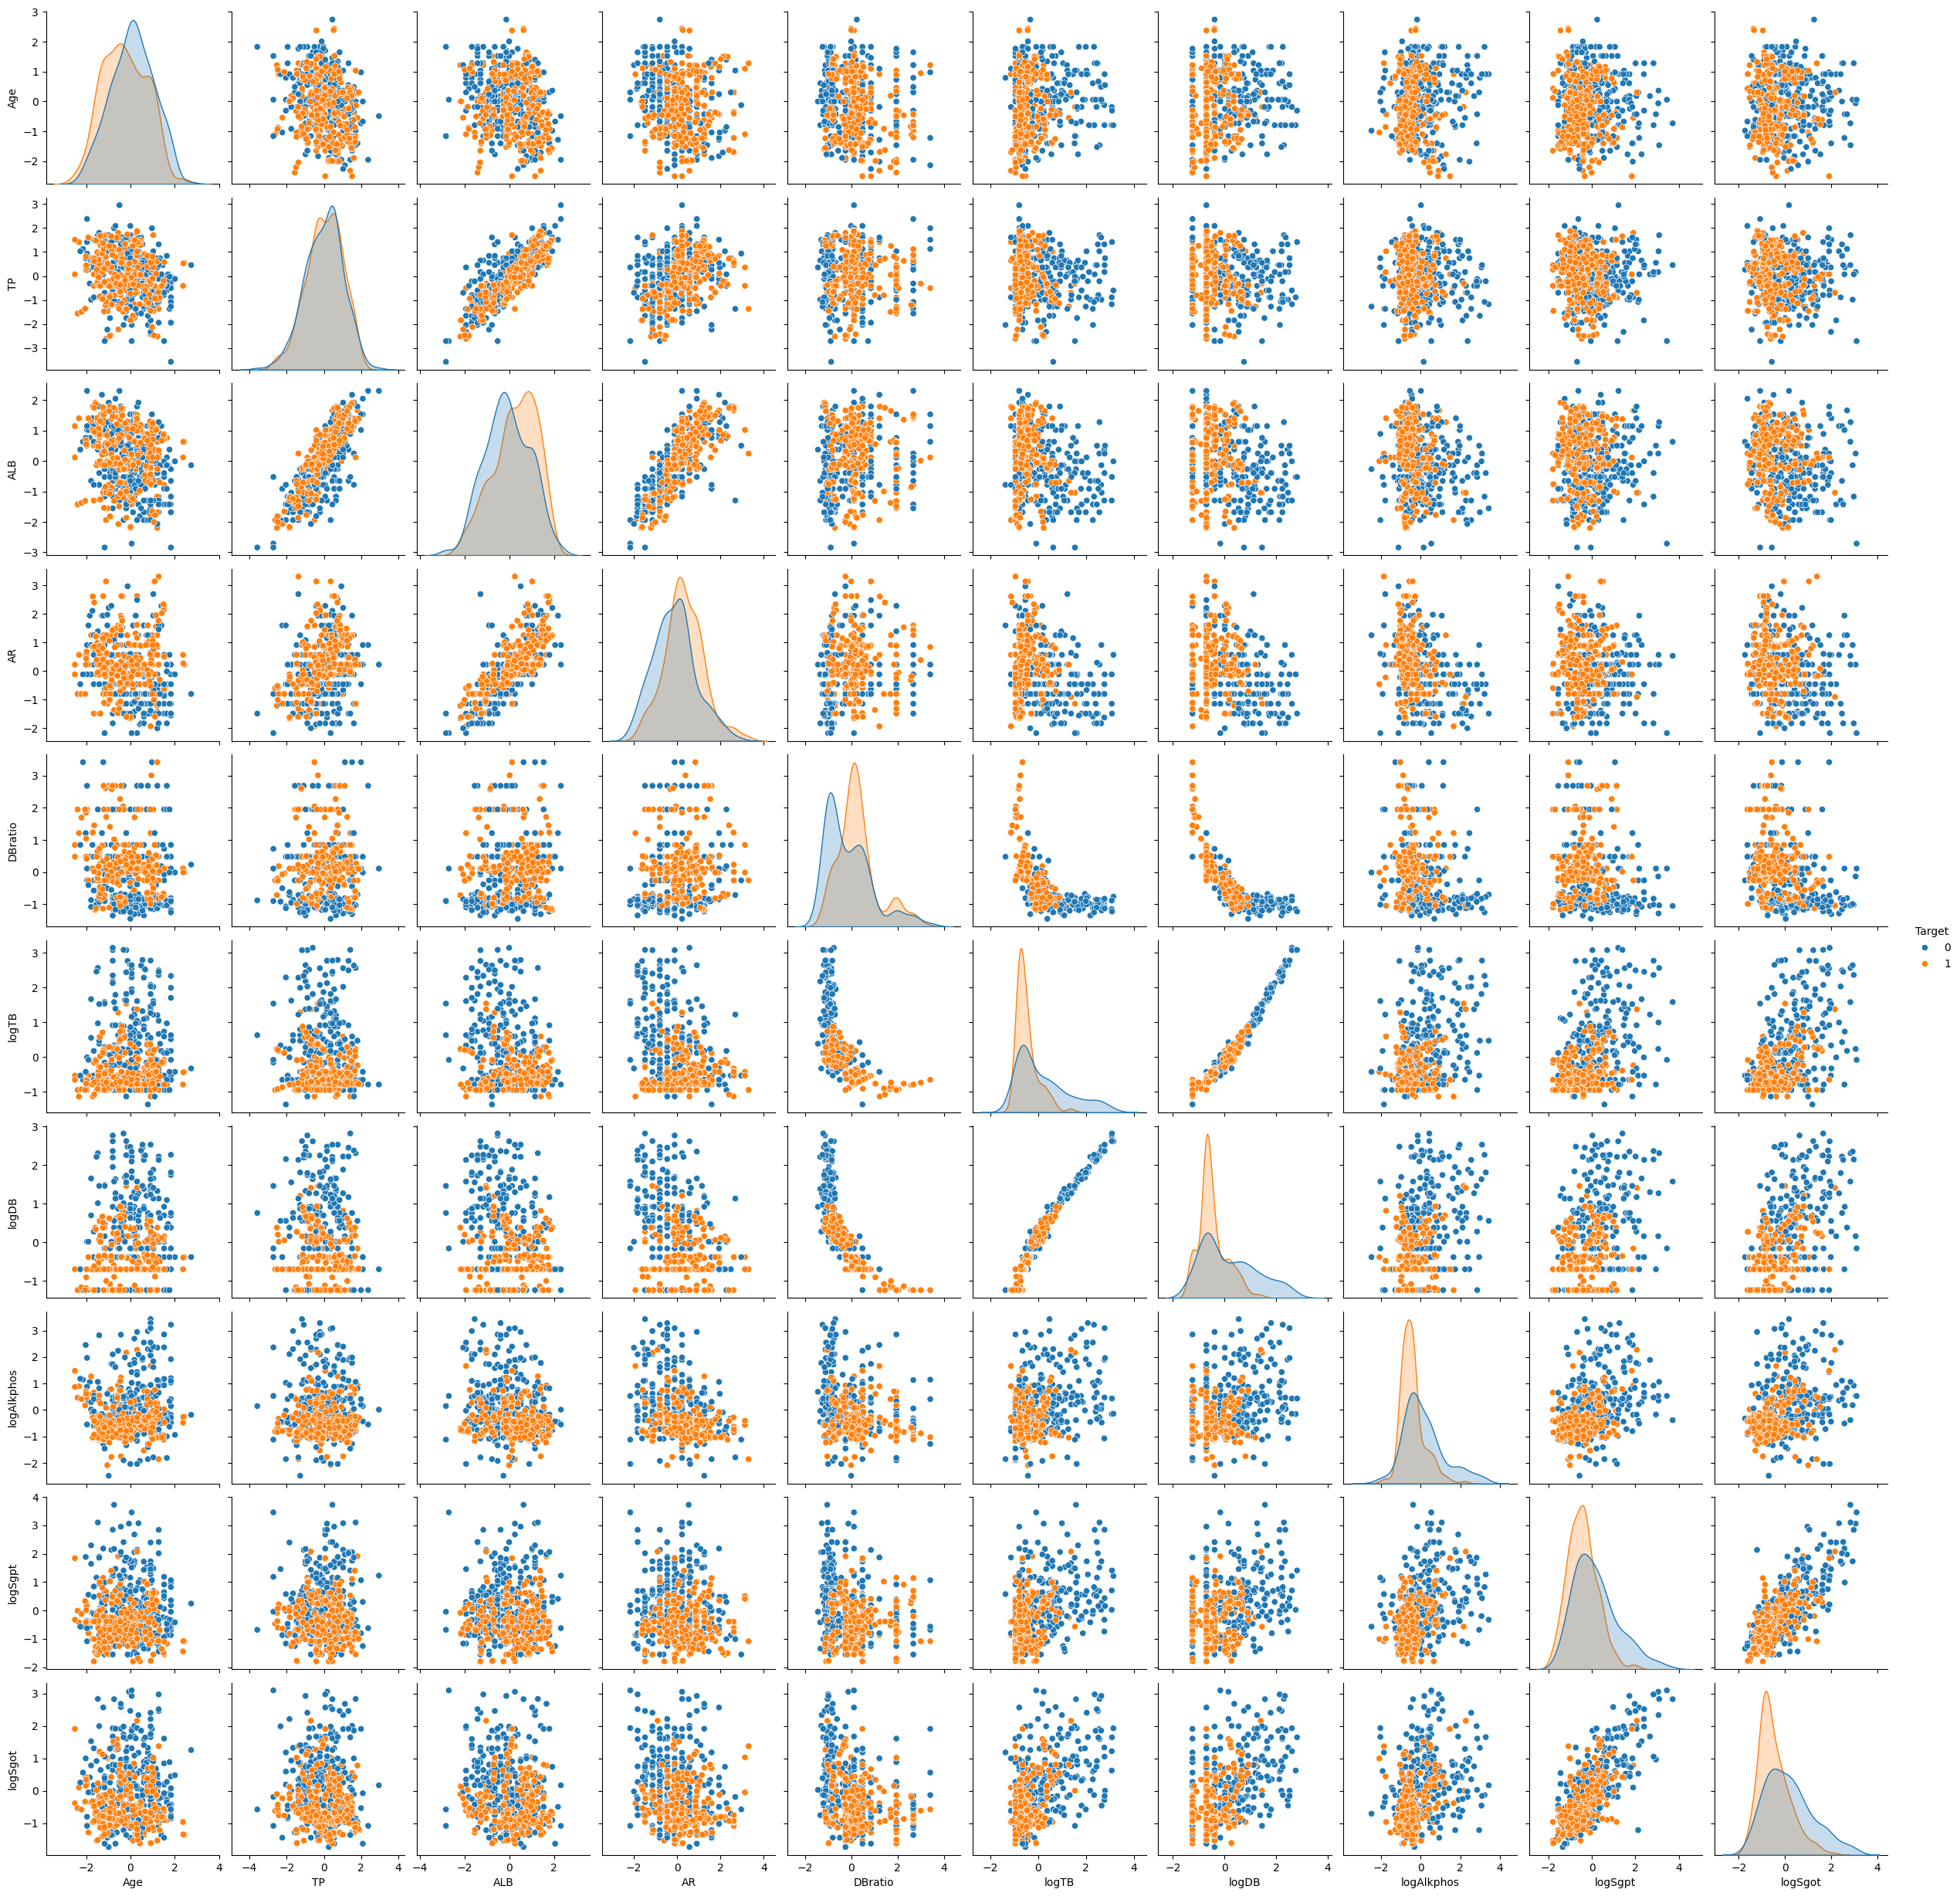

In [130]:
sns.pairplot(log_ILDS_train, hue = "Target")

In [131]:
log_numILDS_train = log_ILDS_train.drop(columns = ["Female", "Target"])
corr = log_numILDS_train.corr()
corr.style.background_gradient(cmap='RdBu')

In [132]:
eigs, U = np.linalg.eig(corr) 
X_pca = log_numILDS_train @ U

print(eigs)
print(X_pca.shape)

[3.88495993e+00 2.12473200e+00 1.21497115e+00 8.73016309e-01
 8.08165811e-01 5.18451086e-01 3.43291610e-01 2.09562966e-01
 2.10825601e-02 1.76657192e-03]
(620, 10)


<Figure size 600x400 with 0 Axes>

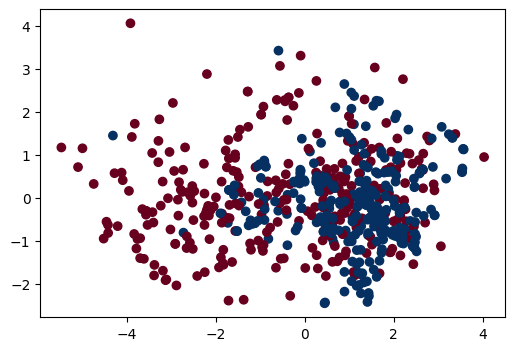

In [133]:
x = X_pca.loc[:, 0]
y = X_pca.loc[:, 2]
z = X_pca.loc[:, 2]

plt.figure(figsize = (6, 4))
plt.scatter(x = x, y = y, c = log_ILDS_train['Target'], cmap = "RdBu")

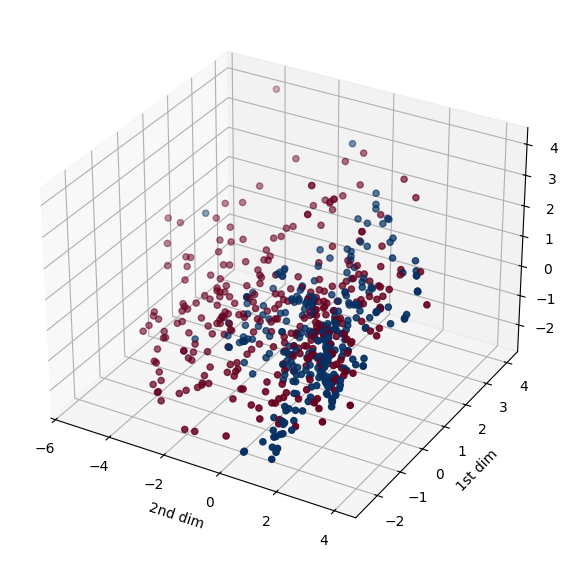

In [134]:
fig = plt.figure(figsize = (7, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs = x, ys = y, zs = z, c = log_ILDS_train['Target'], cmap = "RdBu")

_ = ax.set_xlabel("2nd dim")
_ = ax.set_ylabel("1st dim")
_ = ax.set_zlabel("3rd dim")

# End. Saving results

In [135]:
log_ILDS_train.to_csv('log_ILDS_train_X.csv', index = False)
log_ILDS_test_X.to_csv('log_ILDS_test_X.csv', index = False, header = False)